**JunHao Chen - JC8289**

**Troy Mei - TM2903**


Objective: To predict the final race position of a driver and the probability of each position

Data Used: http://ergast.com/mrd/ - Ergast Developer API provided most of our race data.

Sources Referenced: Borrowed ideas from https://medium.com/@timothychong/talk-data-to-me-modeling-of-singapore-grand-prix-2018-b7e04355d54f where championship points represented confidence level before the race. We built upon it and used constructor pointers before the race as well. 

**JunHao Chen - Data Acqusition, Logistic Regression, SVM**

Data Acqusition by calling Ergast Developer API. Used race data from 2006 - 2019 only.

Due to the nature of the sport and the technological development of Formula 1 cars, it seems bizarre to use old race data from the 1900s where the cars were less advanced and were far slower. We felt like old data could skew our model and objective to predict recent Formula 1 Grand Prix wins. 

2006 - 2013: the introcution of the V8 engines and the modern KERS (Kinetic Energy Recovery Systems unit

2014 - Current: V6 hybrid engines

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Call Ergast Developer API and gather data and insert data into an CSV file.


In [0]:
import requests
import json
import copy


def convertTimeToInt(time):
  time = [char for char in time] 
  time[4] = ":"
  time = "".join(time)
  (m, s, ms) = time.split(':')
  result = float(m) * 60 + float(s) + float(s) * 1/100

  return (str(result))

#get race results of a specific season 
def getRaceResultErgast(season,CSV):


  raceResults = requests.get('http://ergast.com/api/f1/{}/results.json?limit=1000'.format(season))
  qualiResults = requests.get('http://ergast.com/api/f1/{}/qualifying.json?limit=1000'.format(season))

  qualiResults = qualiResults.json()
  results = raceResults.json()
  raceCount = 0
  championshipPoints = {}
  oldConstructorPoints = {}
  constructorPoints = {}
  championshipVic = {}
  championshipPole = {}
  constructorVic = {}
  constructorPole = {}


  for i in results['MRData']['RaceTable']['Races']:
    raceDict = {}
    champWin = 0
    qualiWin = 0

    #for quali results for each race
    for j in qualiResults['MRData']['RaceTable']['Races'][raceCount]['QualifyingResults']:
      name = j['Driver']['givenName'] + ' ' + j['Driver']['familyName']

      if qualiWin == 0:
        if name not in championshipPole:
          championshipPole[name] = 1
        else:
          championshipPole[name] += 1

        if j['Constructor']['name'] not in constructorPole:
          constructorPole[ j['Constructor']['name'] ] = 1
        else:
          constructorPole[ j['Constructor']['name'] ] += 1

      try:
        q1 = ( j['Q1'] )
        q1 = convertTimeToInt(q1)
      except:
        q1 = '0:00:000'
        q1 = convertTimeToInt(q1)
      try:
        q2 = ( j['Q2'] )
        q2 = convertTimeToInt(q2)
      except:
        q2 = q1
      try:
        q3 = ( j['Q3'] )
        q3 = convertTimeToInt(q3)
      except:
        q3 = q2
      quali = [q1,q2,q3]
      raceDict[name] = quali
      qualiWin += 1

      #get constructor standing before each race

    for j in i['Results']:
      # print(j)
      # print(j['position'] + j['grid'] + j['Driver']['givenName'] + j['Driver']['familyName'] + j['Constructor']['name'])
      name = j['Driver']['givenName'] + ' ' + j['Driver']['familyName']
      constructorName = j['Constructor']['name']

      if champWin == 0:
        if name not in championshipVic:
          championshipVic[name] = 1
        else:
          championshipVic[name] += 1

        if constructorName not in constructorVic:
          constructorVic[ constructorName ] = 1
        else:
          constructorVic[ constructorName ] += 1

      row = []
      row.append(str(season))
      row.append(i['raceName'])
      row.append(j['position'])
      row.append(j['grid'])
      try:
        quali = raceDict[name]
        row.append(quali[0])
        row.append(quali[1])
        row.append(quali[2])
      except:
        row.append('0')
        row.append('0')
        row.append('0')
      row.append(name)
      row.append(j['Constructor']['name'])


       # no points for first race
      if raceCount == 0:
        row.append('0')
        row.append('0')
        row.append('0')
        row.append('0')
        row.append('0')
        row.append('0')
      else:
        try:
          row.append(str(championshipPoints[name]))
        except:
          row.append('0')
        try:
          row.append(str(championshipVic[name]))
        except:
          row.append('0')
        try:
          row.append(str(championshipPole[name]))
        except:
          row.append('0')
        try:
          row.append(str(oldConstructorPoints[constructorName]))
        except:
          row.append('0')
        try:
          row.append(str(constructorVic[constructorName]))
        except:
          row.append('0')
        try:
          row.append(str(constructorPole[constructorName]))
        except:
          row.append('0')

      if name not in championshipPoints:
        championshipPoints[name] = float(j['points'])
      else:
        championshipPoints[name] += float(j['points'])

      if constructorName not in constructorPoints:
        constructorPoints[constructorName] = float(j['points'])
      else:
        constructorPoints[constructorName] += float(j['points'])
      

      row = ','.join(row)
      print(row, file = CSV)
      champWin +=1
    raceCount+=1
    oldConstructorPoints = copy.deepcopy(constructorPoints)

#get desired results and parse it into CSV
def getResults():
  resultCSV = open('drive/My Drive/results.csv', 'w')
  print("Year,Race,Final Position,Qualifying Position,Q1,Q2,Q3,Name,Team, Championship Points, Race Vic, Race Pole,Constructor Points, Team Vic, Team Pole",file=resultCSV)


  for i in range(2006,2019):
    getRaceResultErgast(str(i),resultCSV)
  
  resultCSV.close()
  
getResults()


In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn import svm

**You have to manually convert the CSV file into Excel format and upload onto drive**

Load Excel file into dataframe

I've shared the Excel formatted version at https://drive.google.com/file/d/1WwxQ8t22FjyL-lElfrMvCqM8kyIVKsRr/view?usp=sharing for easier access


In [0]:
df = pd.read_excel("drive/My Drive/results.xlsx")
df.head()

,Year,Race,Final Position,Qualifying Position,Q1,Q2,Q3,Name,Team,Championship Points,Race Vic,Race Pole,Constructor Points,Team Vic,Team Pole
0,2006,Bahrain Grand Prix,1,4,92.32,91.31,91.31,Fernando Alonso,Renault,0.0,0,0,0.0,0,0
1,2006,Bahrain Grand Prix,2,1,93.33,92.32,91.31,Michael Schumacher,Ferrari,0.0,0,0,0.0,0,0
2,2006,Bahrain Grand Prix,3,22,0.00,0.00,0.00,Kimi Räikkönen,McLaren,0.0,0,0,0.0,0,0
3,2006,Bahrain Grand Prix,4,3,92.32,92.32,91.31,Jenson Button,Honda,0.0,0,0,0.0,0,0
4,2006,Bahrain Grand Prix,5,5,93.33,91.31,92.32,Juan Pablo Montoya,McLaren,0.0,0,0,0.0,0,0


Transforming categorical data into numbered labels. EX: Race, Team, Name

In [0]:
#generating labels for names/teams/races
races = np.unique(df['Race'])
# print(races)

LE = LabelEncoder()
race_labels = LE.fit_transform(df['Race'])
race_mappings = {index: label for index, label in enumerate(LE.classes_)}
# print(race_mappings)
df['RaceLabel'] = race_labels

names = np.unique(df['Name'])
name_labels = LE.fit_transform(df['Name'])
name_mappings = {index: label for index, label in enumerate(LE.classes_)}
# print(name_mappings)
df['NameLabel'] = name_labels

teams = np.unique(df['Team'])
team_labels = LE.fit_transform(df['Team'])
team_mappings = {index: label for index, label in enumerate(LE.classes_)}
# print(team_mappings)
df['TeamLabel'] = team_labels

df.head()

,Year,Race,Final Position,Qualifying Position,Q1,Q2,Q3,Name,Team,Championship Points,Race Vic,Race Pole,Constructor Points,Team Vic,Team Pole,RaceLabel,NameLabel,TeamLabel
0,2006,Bahrain Grand Prix,1,4,92.32,91.31,91.31,Fernando Alonso,Renault,0.0,0,0,0.0,0,0,4,20,16
1,2006,Bahrain Grand Prix,2,1,93.33,92.32,91.31,Michael Schumacher,Ferrari,0.0,0,0,0.0,0,0,4,48,3
2,2006,Bahrain Grand Prix,3,22,0.00,0.00,0.00,Kimi Räikkönen,McLaren,0.0,0,0,0.0,0,0,4,38,13
3,2006,Bahrain Grand Prix,4,3,92.32,92.32,91.31,Jenson Button,Honda,0.0,0,0,0.0,0,0,4,29,7
4,2006,Bahrain Grand Prix,5,5,93.33,91.31,92.32,Juan Pablo Montoya,McLaren,0.0,0,0,0.0,0,0,4,31,13


Target Feature = Final Position

Features = Everything else

In [0]:
y = np.unique( df['Final Position'].values,return_inverse=True)[1]
x = df[['Year','Qualifying Position','Q1','Q2','Q3','Championship Points','Race Vic', 'Race Pole','Constructor Points','Team Vic','Team Pole','RaceLabel','NameLabel','TeamLabel']]
x = x.values

Initial Accuracy with just tran_test_split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

logreg = linear_model.LogisticRegression(C=1)
logreg.fit(x_train,y_train)

yhat = logreg.predict(x_test)
accuracy = np.mean(yhat == y_test)
print("Accuracy of training = {}".format(accuracy))

Accuracy of training = 0.12943372744243933


Calculate mean accuracy and standardard error with KFold cross validation

In [0]:
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = []
 
for ifold, Ind in enumerate(kf.split(x)):  
  
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    acc.append(np.mean(yhat == yts))


SE = np.std(acc) / np.sqrt(nfold)
print("Mean Accuracy rate = {} , SE = {}".format(np.mean(acc),SE))

Mean Accuracy rate = 0.12605454038220115 , SE = 0.003512850389355727


Weights of each feature from the logistic regression

<StemContainer object of 3 artists>

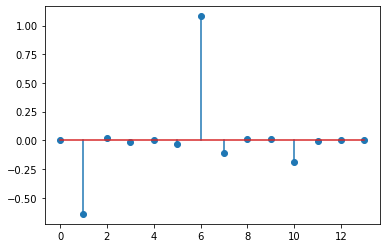

In [0]:
logreg.fit(x,y)
W = logreg.coef_
# print(W)
plt.stem(W[0,:])


Features = *Year*, Qualifying Position, Q1, Q2, Q3 ,Championship Points, Race Vic, Race Pole,Constructor Points, Team Vic, Team Pole , RaceLabel , NameLabel ,TeamLabel


We see that Qualifying Position has interstingly negative weight.

Race victory has the strongest correlation with predicting final position which makes sense because Formula 1 wins are heavily dominated by the car and less by  the skills of the driver.

Now we try to apply L1 regularization to make the weights sparse by penaliziing 0's

We're also optimizing L1 by finding an optimal C

In [0]:
npen = 20
C_test = np.logspace(-3,-1,npen)

# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))
num_nonzerocoef = np.zeros((npen,nfold))
# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)

# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(x)):        
            
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Loop over penalty levels
    for ipen, c in enumerate(C_test):
        
        # Set the penalty level        
        logreg.C= c
    
        # Fit a model on the training data
        logreg.fit(Xtr, ytr)
    
        # Predict the labels on the test set.
        yhat = logreg.predict(Xts)
        
        # Measure the accuracy
        err_rate[ipen,ifold] = np.mean(yhat != yts)

    print("Fold %d" % ifold)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


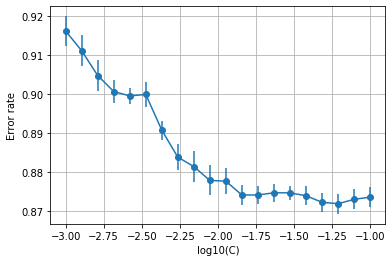

The minimum test error rate = 0.871896359324871, SE=0.0026109700964270875
The C value corresponding to minimum error = 0.06158482110660261


In [0]:
err_mean = np.mean(err_rate, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.xlabel('log10(C)')
plt.ylabel('Error rate')
plt.grid()
plt.show()
imin = np.argmin(err_mean)

print("The minimum test error rate = {}, SE={}".format(err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = {}".format(C_test[imin]))

The optimal inverse regularization strength is 0.0616 so now we construct the model with L1 regularization using the optimal C

In [0]:
logreg = linear_model.LogisticRegression(C=C_test[imin],penalty='l1')
confusion = np.zeros((24,24))
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = []
# 8 classes so 8 for matrix size
 
for ifold, Ind in enumerate(kf.split(x)):  
  
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    acc.append(np.mean(yhat == yts))
    confusion += confusion_matrix(yts,yhat)


SE = np.std(acc) / np.sqrt(nfold)
tempSum = np.sum(confusion,1)
confusion = confusion / tempSum[np.newaxis,:]
print("Mean Accuracy rate = {} , SE = {}".format(np.mean(acc),SE))



Mean Accuracy rate = 0.12624145627005162 , SE = 0.00509793928972676


Our mean accuracy slightly improved with optimal L1 regularization from 0.12605454038220115 to 0.12624145627005162

The confusion matrix for the model is presented below. The probability of predicting final position X given actual position X

(24.5, -0.5)

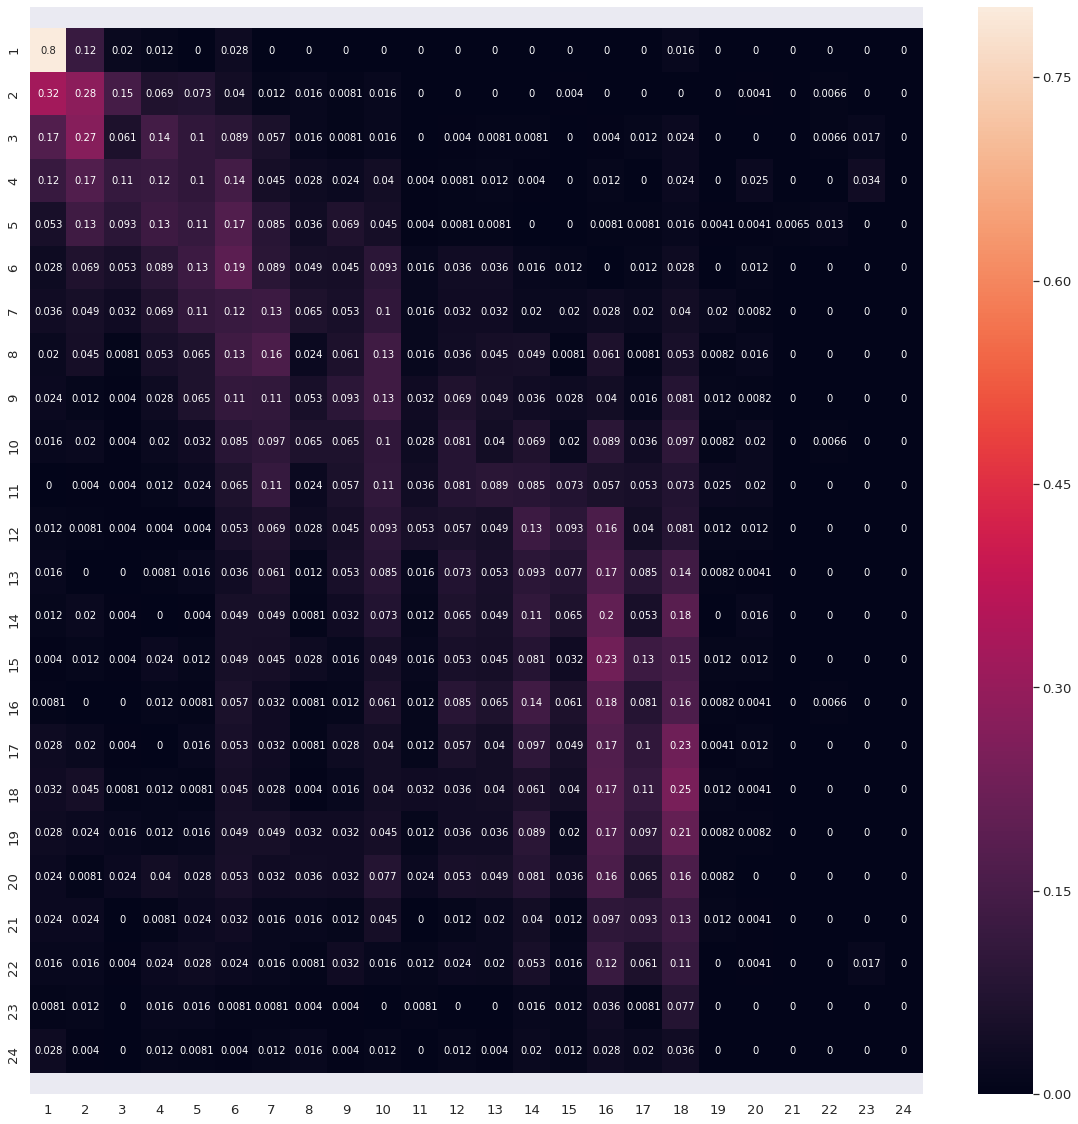

In [0]:
df_cm = pd.DataFrame(confusion, index = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]],
                  columns = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]])
plt.figure(figsize = (20,20))

sn.set(font_scale=1.2)#for label size
ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Based on the Confusion Matrix, we see that it does pretty well predicting 1st place, but struggles with the rest of positions due to the unpredictiability in the mid-field teams. Many things race can occur in a race so it is no surprise that the accuracy is quite low. 

What's suprising about this is that it does pretty poorly predicting second place 

Comparsion of weights without L1 and with L1 regularixation

Text(0.5, 1.0, 'l1-regularization')

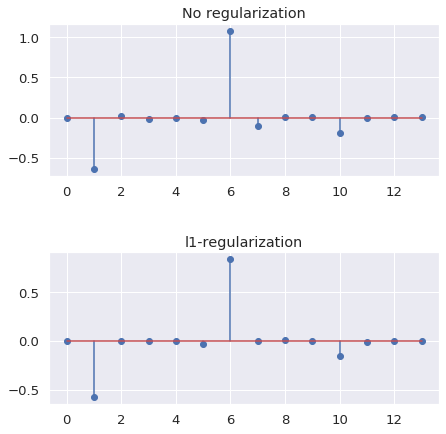

In [0]:
W_l1 = logreg.coef_
plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
# plt.ylim((-0.75,0.05))
plt.subplots_adjust(hspace=.5)
plt.stem(W[0,:])
plt.title('No regularization')
plt.subplot(2,1,2)
# plt.ylim((-0.75,0.05))
plt.stem(W_l1[0,:])
plt.title('l1-regularization')

Now we will try a multi-class logistic regression 

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Mean Accuracy rate = 0.12492676802901378 , SE = 0.0025905347217149597


(24.5, -0.5)

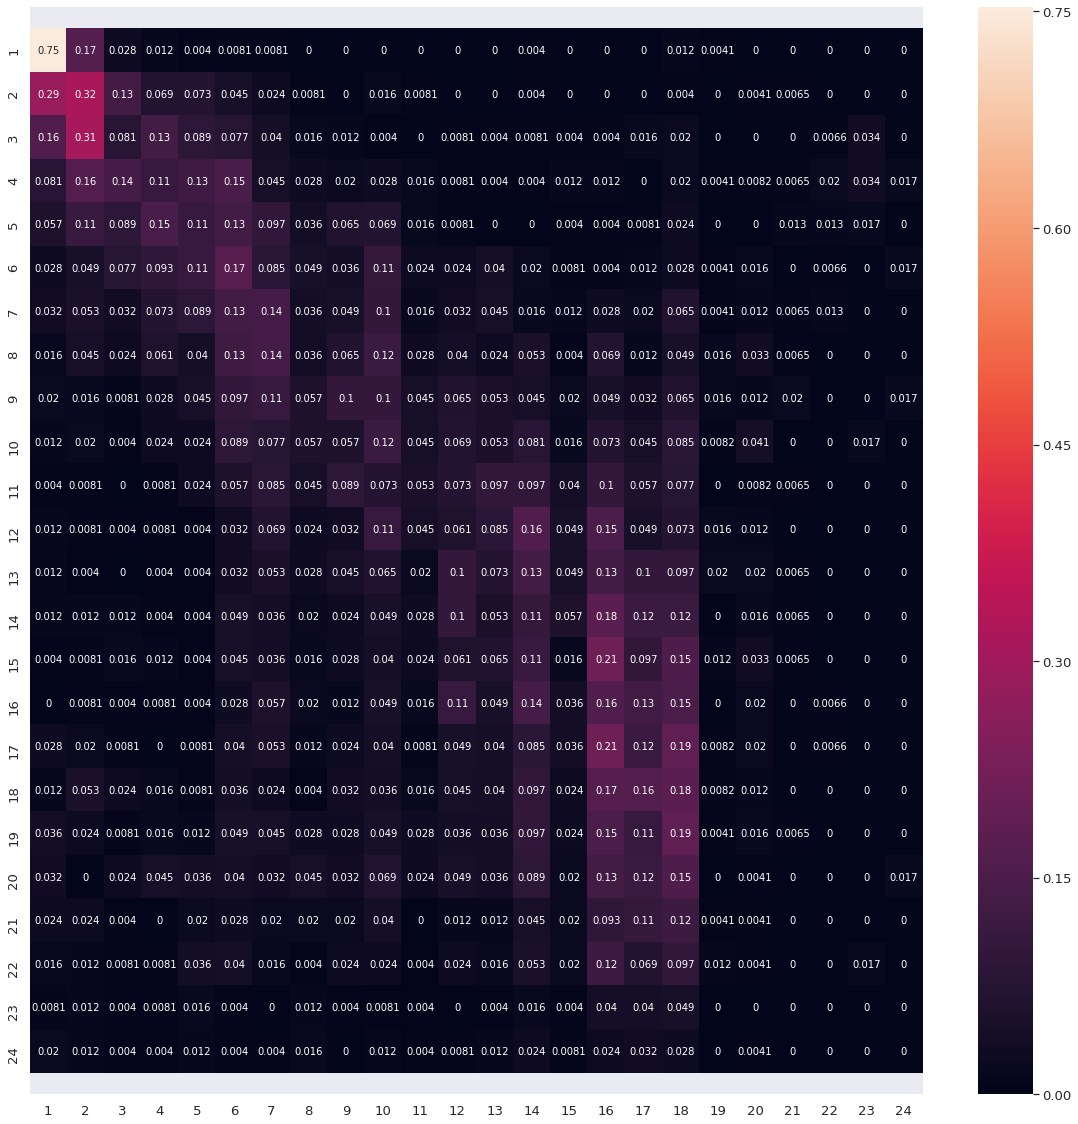

In [0]:
logreg = linear_model.LogisticRegression(solver='newton-cg', multi_class='multinomial')
confusion = np.zeros((24,24))
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = []
# 8 classes so 8 for matrix size
 
for ifold, Ind in enumerate(kf.split(x)):  
  
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    acc.append(np.mean(yhat == yts))
    confusion += confusion_matrix(yts,yhat)

    print("Fold %d" % ifold)


SE = np.std(acc) / np.sqrt(nfold)
tempSum = np.sum(confusion,1)
confusion = confusion / tempSum[np.newaxis,:]
print("Mean Accuracy rate = {} , SE = {}".format(np.mean(acc),SE))

df_cm = pd.DataFrame(confusion, index = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]],
                  columns = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]])
plt.figure(figsize = (20,20))

sn.set(font_scale=1.2)#for label size
ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Mean accuracy using multi-class model performed slightly worse with  0.12492676802901378 compared to logistic regression of 0.12624145627005162

Now we try to optimize C for multi-class model with L2 regularization since multi-class does not offer L1

In [0]:
npen = 10
C_test = np.logspace(-3,-1,npen)
# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))
num_nonzerocoef = np.zeros((npen,nfold))
# Create the logistic regression object
logreg = linear_model.LogisticRegression(solver='newton-cg', multi_class='multinomial', penalty='l2')
# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(x)):        
            
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Loop over penalty levels
    for ipen, c in enumerate(C_test):
        
        # Set the penalty level        
        logreg.C= c
    
        # Fit a model on the training data
        logreg.fit(Xtr, ytr)
    
        # Predict the labels on the test set.
        yhat = logreg.predict(Xts)
        
        # Measure the accuracy
        err_rate[ipen,ifold] = np.mean(yhat != yts)
    print("Fold %d" % ifold)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


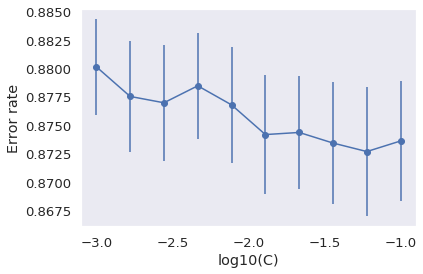

The minimum test error rate = 0.8726429767052588, SE=0.005711257265191925
The C value corresponding to minimum error = 0.05994842503189409


In [0]:
err_mean = np.mean(err_rate, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.xlabel('log10(C)')
plt.ylabel('Error rate')
plt.grid()
plt.show()
imin = np.argmin(err_mean)

print("The minimum test error rate = {}, SE={}".format(err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = {}".format(C_test[imin]))

In [0]:
logreg = linear_model.LogisticRegression(C=C_test[imin], solver='newton-cg', multi_class='multinomial', penalty='l2')
confusion = np.zeros((24,24))
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = []
# 8 classes so 8 for matrix size
 
for ifold, Ind in enumerate(kf.split(x)):  
  
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    acc.append(np.mean(yhat == yts))
    confusion += confusion_matrix(yts,yhat)


SE = np.std(acc) / np.sqrt(nfold)
tempSum = np.sum(confusion,1)
confusion = confusion / tempSum[np.newaxis,:]
print("Mean Accuracy rate = {} , SE = {}".format(np.mean(acc),SE))

Mean Accuracy rate = 0.12174815176454179 , SE = 0.003204075834675082


(24.5, -0.5)

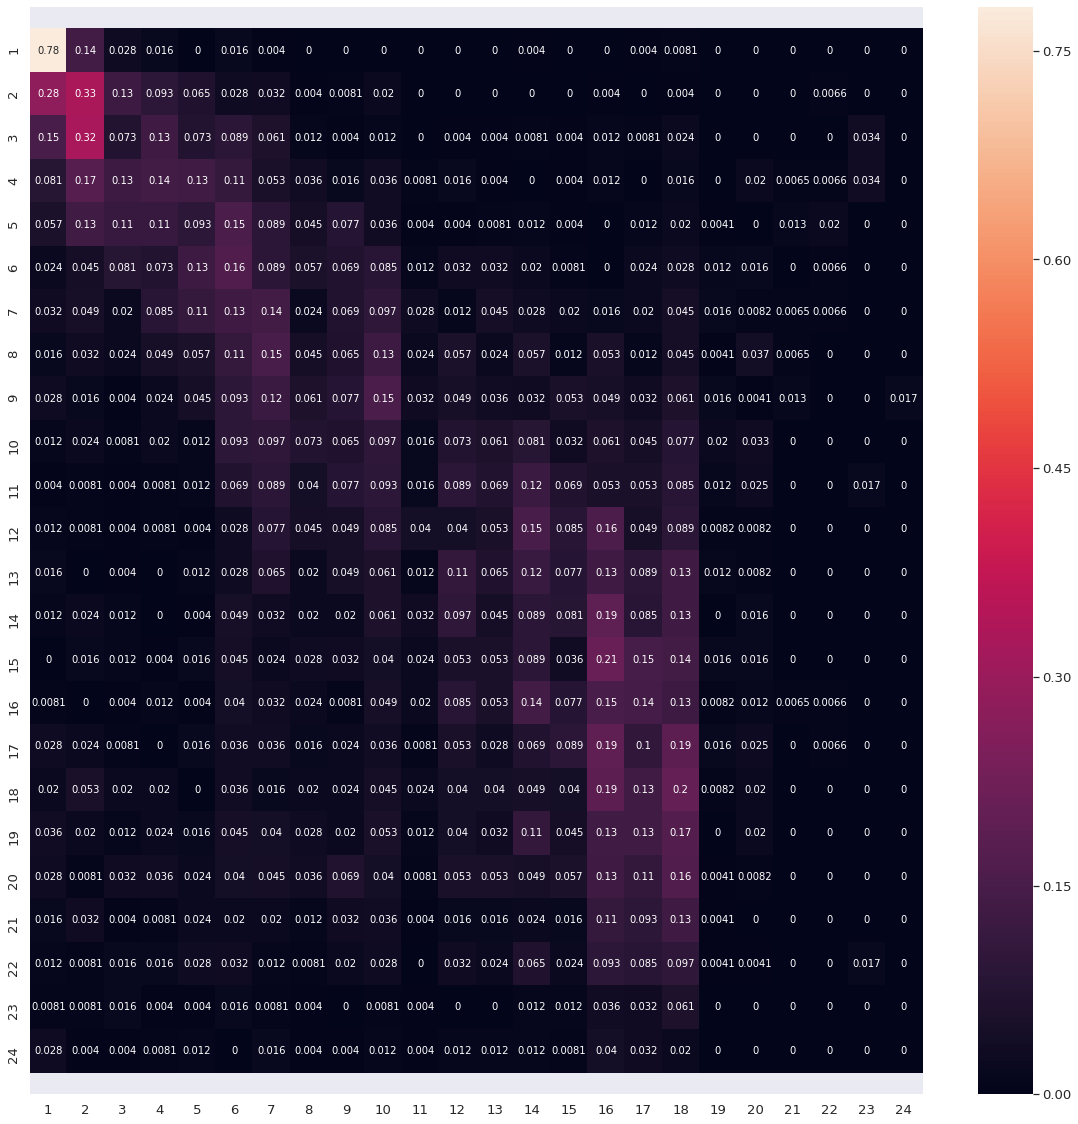

In [0]:
df_cm = pd.DataFrame(confusion, index = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]],
                  columns = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]])
plt.figure(figsize = (20,20))

sn.set(font_scale=1.2)#for label size
ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Trying out SVM Model

In [0]:
from sklearn import svm
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073)

nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = []
# 8 classes so 8 for matrix size
 
for ifold, Ind in enumerate(kf.split(x)):  
  
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Fit a model
    svc.fit(Xtr, ytr)
    yhat = svc.predict(Xts)
    
    # Measure performance
    acc.append(np.mean(yhat == yts))

    print("Fold: %d" %ifold)


SE = np.std(acc) / np.sqrt(nfold)
print("Mean Accuracy rate = {} , SE = {}".format(np.mean(acc),SE))

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Mean Accuracy rate = 0.07955049518761334 , SE = 0.002653943187180351


SVM seems to perform really bad. I assume it is becausse the slack from SVM reduces the accuracy of predicting the exact  position because the difference betwen 5th-7th in the mid-field might be  minimal. 

**Conclusion: Logistic Regession with L1 regularization seems to perform the best**

In [0]:
npen = 20
C_test = np.logspace(-3,-1,npen)

# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))
num_nonzerocoef = np.zeros((npen,nfold))
# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)

# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(x)):        
            
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Loop over penalty levels
    for ipen, c in enumerate(C_test):
        
        # Set the penalty level        
        logreg.C= c
    
        # Fit a model on the training data
        logreg.fit(Xtr, ytr)
    
        # Predict the labels on the test set.
        yhat = logreg.predict(Xts)
        
        # Measure the accuracy
        err_rate[ipen,ifold] = np.mean(yhat != yts)

    print("Fold %d" % ifold)


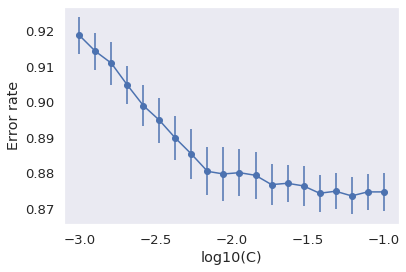

The minimum test error rate = 0.8735799972102107, SE=0.0052124396161550264
The C value corresponding to minimum error = 0.06158482110660261


In [0]:
err_mean = np.mean(err_rate, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.xlabel('log10(C)')
plt.ylabel('Error rate')
plt.grid()
plt.show()
imin = np.argmin(err_mean)

print("The minimum test error rate = {}, SE={}".format(err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = {}".format(C_test[imin]))

In [0]:
logreg = linear_model.LogisticRegression(C=C_test[imin],penalty='l1')
confusion = np.zeros((24,24))
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
acc = []
 
for ifold, Ind in enumerate(kf.split(x)):  
  
    # Get training and test data
    Itr, Its = Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    acc.append(np.mean(yhat == yts))
    confusion += confusion_matrix(yts,yhat)


SE = np.std(acc) / np.sqrt(nfold)
tempSum = np.sum(confusion,1)
confusion = confusion / tempSum[np.newaxis,:]
print("Mean Accuracy rate = {} , SE = {}".format(np.mean(acc),SE))

Mean Accuracy rate = 0.12755126237969033 , SE = 0.0038867045624915077


(24.5, -0.5)

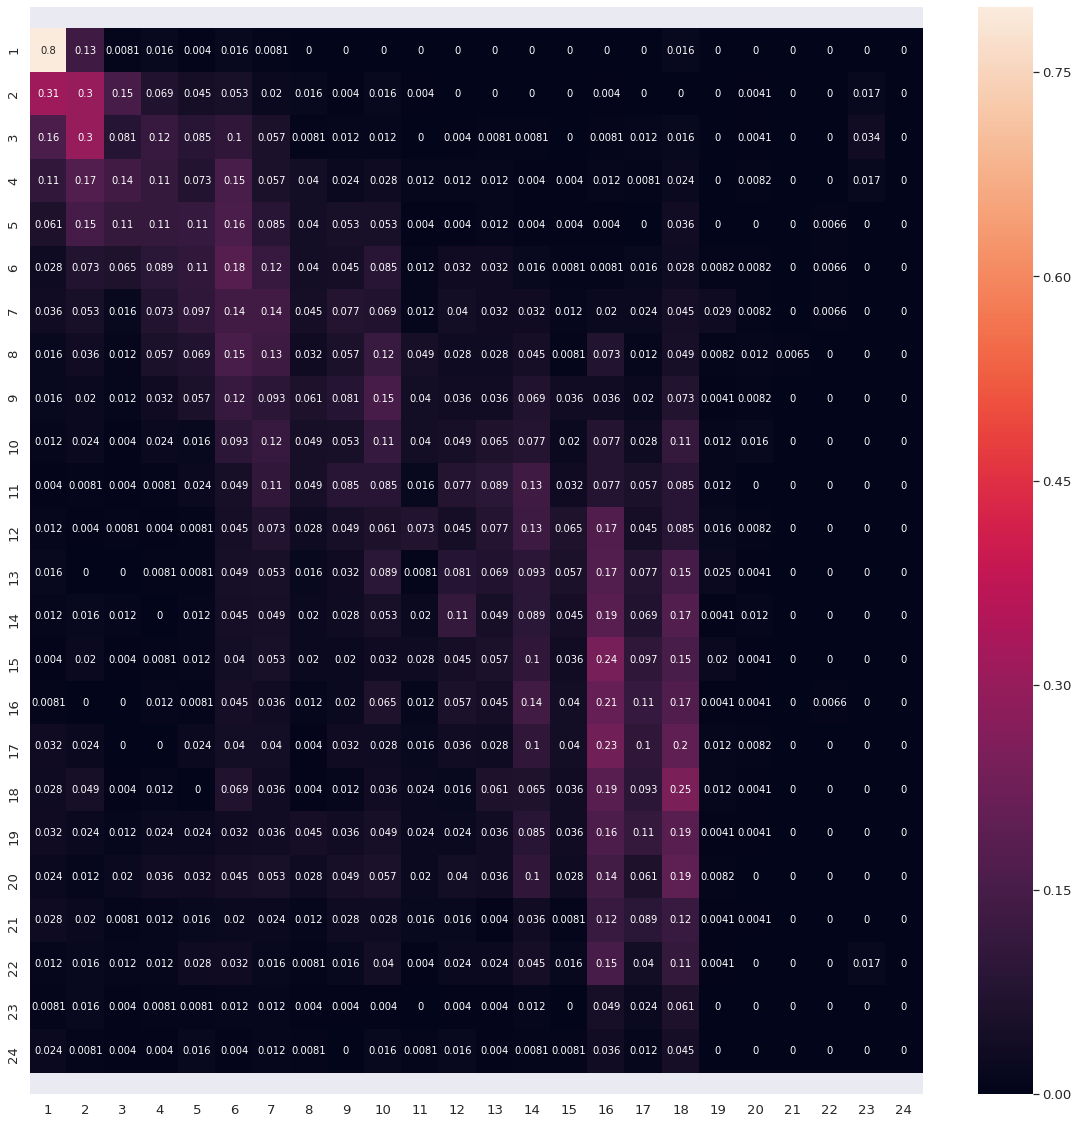

In [0]:
df_cm = pd.DataFrame(confusion, index = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]],
                  columns = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]])
plt.figure(figsize = (20,20))

sn.set(font_scale=1.2)#for label size
ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [0]:
print(race_mappings)
print(team_mappings)
print(name_mappings)

{0: 'Abu Dhabi Grand Prix', 1: 'Australian Grand Prix', 2: 'Austrian Grand Prix', 3: 'Azerbaijan Grand Prix', 4: 'Bahrain Grand Prix', 5: 'Belgian Grand Prix', 6: 'Brazilian Grand Prix', 7: 'British Grand Prix', 8: 'Canadian Grand Prix', 9: 'Chinese Grand Prix', 10: 'European Grand Prix', 11: 'French Grand Prix', 12: 'German Grand Prix', 13: 'Hungarian Grand Prix', 14: 'Indian Grand Prix', 15: 'Italian Grand Prix', 16: 'Japanese Grand Prix', 17: 'Korean Grand Prix', 18: 'Malaysian Grand Prix', 19: 'Mexican Grand Prix', 20: 'Monaco Grand Prix', 21: 'Russian Grand Prix', 22: 'San Marino Grand Prix', 23: 'Singapore Grand Prix', 24: 'Spanish Grand Prix', 25: 'Turkish Grand Prix', 26: 'United States Grand Prix'}
{0: 'BMW Sauber', 1: 'Brawn', 2: 'Caterham', 3: 'Ferrari', 4: 'Force India', 5: 'HRT', 6: 'Haas F1 Team', 7: 'Honda', 8: 'Lotus', 9: 'Lotus F1', 10: 'MF1', 11: 'Manor Marussia', 12: 'Marussia', 13: 'McLaren', 14: 'Mercedes', 15: 'Red Bull', 16: 'Renault', 17: 'Sauber', 18: 'Spyker',

Features = *Year*, Qualifying Position, Q1, Q2, Q3 ,Championship Points, Race Vic, Race Pole,Constructor Points, Team Vic, Team Pole , RaceLabel , NameLabel ,TeamLabel

Predicting 2019 Australian Grand Prix of Lewis Hamilton

Actual: Lewis Hamilton: Q1: 1:22.043	Q2: 1:21.014	Q3: 1:20.486	Pole Position: 1 Final Race Position:2

In [0]:
test = [[2019 , 1 , 82.043 ,61.014 ,60.486 ,0 ,0 ,0 ,0, 0, 0 , 1, 40, 14 ]]
result = logreg.predict(test)
print(result+1)

proba = logreg.predict_proba(test)
print(proba)

[1]
[[0.16108987 0.11546597 0.08827704 0.0695838  0.07034709 0.08589438
  0.06200464 0.0496314  0.05502098 0.04341341 0.03060956 0.02688846
  0.02460075 0.02165354 0.01267968 0.01156981 0.00859482 0.00977716
  0.01574601 0.01898879 0.00694425 0.00668442 0.00108118 0.00345303]]


Predicting 2019 Bahrain Grand Prix of Daniel Ricciardo

Actual: Quali Pos: 10 Q1: 1:29.859	Q2: 1:29.488	Q3: N/A Final Pos: 18

In [0]:
test = [[2019 ,10 , 89.859 ,89.488 ,0 ,0 ,0 ,0 ,6, 0, 0 , 4, 13, 14 ]]
result = logreg.predict(test)
print(result+1)

proba = logreg.predict_proba(test)
print(proba)

[13]
[[0.00209206 0.01309737 0.02605341 0.03642539 0.0006909  0.04420738
  0.010557   0.05208603 0.07066764 0.06351455 0.05710807 0.05740767
  0.1800891  0.06847673 0.04698388 0.04407208 0.02198871 0.04518735
  0.05114299 0.05152163 0.02124341 0.02422029 0.00561502 0.00555134]]


**Troy Mei - Neutral Network**

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K

In [81]:
data = pd.read_excel("drive/My Drive/results.xlsx")

df = pd.DataFrame(data, columns=["Year","Race","Final Position",
                                 "Qualifying Position","Q1","Q2","Q3",
                                 "Name","Team","Championship Points",
                                 "Race Vic","Race Pole","Constructor Points",
                                 "Team Vic","Team Pole"])
#print(df.isnull().any())

input_data = df[["Qualifying Position","Q1","Q2","Q3",
                "Championship Points","Race Vic",
                "Race Pole","Constructor Points",
                "Team Vic","Team Pole","Final Position"]]

n = input_data.shape[0]
input_data = input_data.values

tr_start = 0
tr_end = int(np.floor(0.8*n))
ts_start = tr_end + 1
ts_end = n

tr_data = input_data[tr_start:tr_end]
ts_data = input_data[ts_start:ts_end]

xtr = tr_data[:,0:-1]
ytr = tr_data[:,-1]
xts = ts_data[:,0:-1]
yts = ts_data[:,-1]

xmean = np.mean(xtr,axis=0)
xstd = np.std(xtr,axis=0)
#print(xmean, xstd)
xtr_scale = (xtr-xmean[None,:])/xstd[None,:]
xts_scale = (xts-xmean[None,:])/xstd[None,:]

K.clear_session()

nin = xtr.shape[1]
nout = np.max(ytr)+1
nh = round((nin+nout)/2)
#nh = 256
print(nh, nin, nout)
model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation="relu", name="hidden"))
model.add(BatchNormalization())
model.add(Dense(units=nout, activation="softmax", name="output"))
model.summary()

18.0 10 25.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 18)                198       
_________________________________________________________________
batch_normalization (BatchNo (None, 18)                72        
_________________________________________________________________
output (Dense)               (None, 25)                475       
Total params: 745
Trainable params: 709
Non-trainable params: 36
_________________________________________________________________


In [82]:
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(xtr_scale, ytr, epochs=100, batch_size=100, validation_data=(xts_scale,yts))

Train on 4284 samples, validate on 1070 samples
Epoch 1/100
4284/4284 [==============================] - 0s 54us/sample - loss: 3.3963 - acc: 0.0565 - val_loss: 3.2054 - val_acc: 0.0486
Epoch 2/100
4284/4284 [==============================] - 0s 25us/sample - loss: 3.1946 - acc: 0.0745 - val_loss: 3.0867 - val_acc: 0.0738
Epoch 3/100
4284/4284 [==============================] - 0s 22us/sample - loss: 3.0929 - acc: 0.0962 - val_loss: 3.0139 - val_acc: 0.1075
Epoch 4/100
4284/4284 [==============================] - 0s 22us/sample - loss: 3.0262 - acc: 0.1097 - val_loss: 2.9612 - val_acc: 0.1121
Epoch 5/100
4284/4284 [==============================] - 0s 23us/sample - loss: 2.9702 - acc: 0.1190 - val_loss: 2.9180 - val_acc: 0.1215
Epoch 6/100
4284/4284 [==============================] - 0s 22us/sample - loss: 2.9277 - acc: 0.1256 - val_loss: 2.8789 - val_acc: 0.1308
Epoch 7/100
4284/4284 [==============================] - 0s 22us/sample - loss: 2.8910 - acc: 0.1235 - val_loss: 2.8492 - va

In [88]:
test = np.array( [[1 , 82.043 ,61.014 ,60.486 ,0 ,0 ,0 ,0, 0, 0]] )

result = model.predict(test)
print(result)

[[2.6206630e-25 1.0000000e+00 1.5599000e-31 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.0089665e-38 3.3201757e-27 4.3253647e-23
  1.2997942e-25 3.5848725e-36 9.2289560e-33 4.0921082e-25 1.2057035e-19
  2.4889662e-26 7.4777198e-24 3.2222771e-18 3.9813497e-18 3.4221939e-15]]
